In [0]:
import numpy as np
import tensorflow as tf
from collections import defaultdict
from skimage import io
from keras import layers
from keras.layers import Dropout, Input, concatenate
from keras import models
from keras.models import Model, load_model
from keras import backend as K
from keras.applications import ResNet50
from keras import models
from keras.models import Model, Sequential
from keras.layers import Dropout
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

# Loss function

In [0]:
def triplet_loss(y_true, y_pred):
  del y_true

  total_lenght = y_pred.shape.as_list()[-1]   
   
  anchor = y_pred[:,0:int(total_lenght*1/3)]
  positive = y_pred[:,int(total_lenght*1/3):int(total_lenght*2/3)]
  negative = y_pred[:,int(total_lenght*2/3):int(total_lenght*3/3)]

  dist = "qeuclidean"
  margin = "maxplus"

  positive_distance = K.square(anchor - positive)
  negative_distance = K.square(anchor - negative)
  if dist == "sqeuclidean":
    positive_distance = K.mean(positive_distance, axis=-1, keepdims=True)
    negative_distance = K.mean(negative_distance, axis=-1, keepdims=True)
  elif dist == "qeuclidean":
    positive_distance = tf.math.sqrt(K.sum(positive_distance, axis=-1, keepdims=True))
    negative_distance = tf.math.sqrt(K.sum(negative_distance, axis=-1, keepdims=True))
  loss = positive_distance - negative_distance
  if margin == "maxplus":
    loss = K.maximum(0.0, 1 + loss)
  elif margin == 'softplus':
    loss = K.log(1 + K.exp(loss))

  return K.mean(loss)

# Accuracy function

In [0]:
def accuracy(y_true, y_pred):
  del y_true

  total_lenght = y_pred.shape.as_list()[-1]  

  anchor = y_pred[:,0:int(total_lenght*1/3)]
  positive = y_pred[:,int(total_lenght*1/3):int(total_lenght*2/3)]
  negative = y_pred[:,int(total_lenght*2/3):int(total_lenght*3/3)]
  
  positive_distance = K.square(anchor - positive)
  negative_distance = K.square(anchor - negative)
    
  return K.mean(positive_distance < negative_distance)

# Embedding model

In [0]:
def embedding_model_function(input_shape):

  embedding_model = Sequential()
  embedding_model.add(ResNet50(include_top = False, pooling = 'avg', weights = "imagenet"))
  embedding_model.add(Dropout(0.1))
  embedding_model.add(layers.Dense(1024, activation = "sigmoid"))
  embedding_model.add(Dropout(0.1))
  embedding_model.add(layers.Dense(256, activation = "sigmoid"))

  embedding_model.layers[0].trainable = False

  return embedding_model

In [23]:
embedding_model = embedding_model_function((224, 224, 3))
embedding_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dropout_11 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_12 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               262400    
Total params: 25,948,288
Trainable params: 2,360,576
Non-trainable params: 23,587,712
_________________________________________________________________


# Triplet model

In [0]:
def triplet_model_function(embedding_model_function, input_shape):
  anchor_input = Input(input_shape, name='anchor_input')
  positive_input = Input(input_shape, name='positive_input')
  negative_input = Input(input_shape, name='negative_input')
    
  anchor_embedding = embedding_model(anchor_input)
  positive_embedding = embedding_model(positive_input)
  negative_embedding = embedding_model(negative_input)

  inputs = [anchor_input, positive_input, negative_input]
  merged_vector = concatenate([anchor_embedding, positive_embedding, negative_embedding], axis=-1, name='merged_layer')

  triplet_model = Model(inputs=inputs, outputs=merged_vector)
  triplet_model.add_metric(K.mean(accuracy(merged_vector, merged_vector)), "my_acc")

  return triplet_model

# Functions for triplets generation (faseScrub)

In [0]:
def get_triples_indices(grouped, n):
    num_classes = len(grouped)
    list_labels = list(grouped.keys())
    list_labels_copy = list_labels.copy()
    for label in list_labels_copy:
      if len(grouped[label]) < 2:
        list_labels.remove(label)
    pairs = []
    for i in range(0,n,1):
        pairs.append(np.random.choice(list_labels, size=2, replace = False))
    pairs = np.array(pairs)
    positive_labels = pairs[:,0]
    negative_labels = pairs[:,1]
    triples_indices = []
    for positive_label, negative_label in zip(positive_labels, negative_labels):
        negative = np.random.choice(grouped[negative_label])
        positive_group = grouped[positive_label]
        m = len(positive_group)
        anchor_j = np.random.randint(0, m)
        anchor = positive_group[anchor_j]
        positive_j = (np.random.randint(1, m) + anchor_j) % m
        positive = positive_group[positive_j]
        triples_indices.append([anchor, positive, negative])
    return np.asarray(triples_indices)

def get_triples_data(x, grouped, n, image_path):
    indices = get_triples_indices(grouped, n)
    x1,x2,x3 = [],[],[]
    for i in indices[:,0]:
      x1.append(io.imread(image_path + "/" + str(x[i]) + ".jpg"))
    for i in indices[:,1]:
      x2.append(io.imread(image_path + "/" + str(x[i]) + ".jpg"))
    for i in indices[:,2]:
      x3.append(io.imread(image_path + "/" + str(x[i]) + ".jpg"))
    x1 = np.array(x1)
    x2 = np.array(x2)
    x3 = np.array(x3)
    return x1, x2, x3
    
def triplet_generator(x, y, batch_size, image_path):
    grouped = defaultdict(list)
    for i, label in enumerate(y):
        grouped[label].append(i)
       
    while True:
        x_anchor, x_positive, x_negative = get_triples_data(x, grouped, batch_size, image_path)
        yield ({'anchor_input': x_anchor,
               'positive_input': x_positive,
               'negative_input': x_negative},
               np.zeros(len(x_anchor)))

# Reading metadata

In [0]:
!cp -a "/content/drive/My Drive/Colab/Roonyx/Face recognition/faceScrub/croped_images_224" "/content/croped_images_224"
!cp -a "/content/drive/My Drive/Colab/Roonyx/Face recognition/faceScrub/metadata/metadata_small.npz" "/content/metadata_small.npz"

In [0]:
readed = np.load('/content/metadata_small.npz')
metadata = readed["metadata_small"]
x = metadata[:,0]
x = np.array(x, dtype='int64')
y = metadata[:,1]
y = np.array(y, dtype='int64')
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0)

# Model training

In [28]:
embedding_model = embedding_model_function(input_shape = (224, 224, 3))
triplet_model = triplet_model_function(embedding_model, input_shape = (224, 224, 3))
triplet_model.compile(loss=triplet_loss, optimizer='adam')

batch_size = 10
image_path = "/content/croped_images_224"

history = triplet_model.fit_generator(triplet_generator(X_train, y_train, batch_size, image_path),
                                      steps_per_epoch=10,
                                      epochs=30,
                                      validation_data=triplet_generator(X_test, y_test, batch_size, image_path),
                                      validation_steps = len(y_test)//10,
                                      verbose=1)

Epoch 1/30
10/10 [==============================] - 110s 11s/step - loss: 0.9505 - my_acc: 0.5093 - val_loss: 0.8396 - val_my_acc: 0.6050
Epoch 2/30
10/10 [==============================] - 101s 10s/step - loss: 0.7104 - my_acc: 0.5576 - val_loss: 0.8723 - val_my_acc: 0.6619
Epoch 3/30
10/10 [==============================] - 101s 10s/step - loss: 0.4594 - my_acc: 0.6162 - val_loss: 0.4640 - val_my_acc: 0.7106
Epoch 4/30
10/10 [==============================] - 101s 10s/step - loss: 0.3103 - my_acc: 0.6557 - val_loss: 0.3903 - val_my_acc: 0.7019
Epoch 5/30
10/10 [==============================] - 101s 10s/step - loss: 0.2903 - my_acc: 0.6706 - val_loss: 0.6263 - val_my_acc: 0.7124
Epoch 6/30
10/10 [==============================] - 102s 10s/step - loss: 0.2306 - my_acc: 0.6743 - val_loss: 0.2472 - val_my_acc: 0.6959
Epoch 7/30
10/10 [==============================] - 101s 10s/step - loss: 0.2047 - my_acc: 0.6878 - val_loss: 0.2711 - val_my_acc: 0.7023
Epoch 8/30
10/10 [================

# Model loss and accuracy

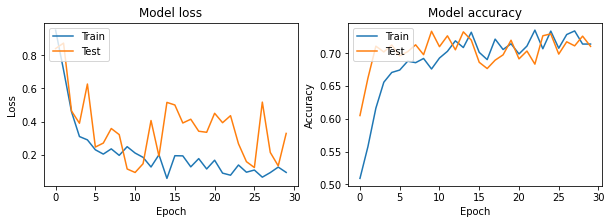

In [31]:
plt.figure(figsize=(10,3))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['my_acc'])
plt.plot(history.history['val_my_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [0]:
# triplet_model.save("/content/drive/My Drive/Colab/Roonyx/Face recognition/faceScrub/metadata" + '/triplet_resnet50(70%).h5')
# triplet_model = load_model("/content/drive/My Drive/Colab/Roonyx/Face recognition/faceScrub/metadata" + '/triplet_resnet50(70%).h5', custom_objects = {"triplet_loss": triplet_loss})